## Bibliotek

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Simulering

### S21 og stabilitet

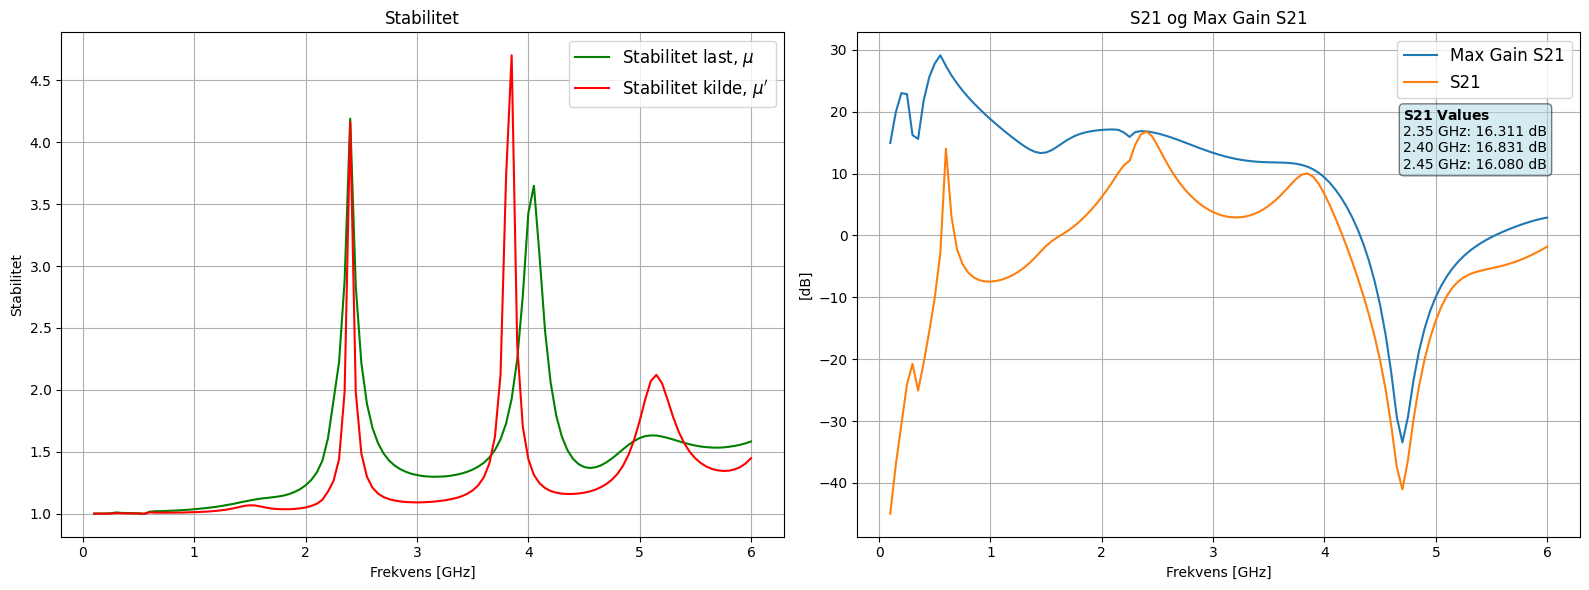

In [78]:
stabilitet = np.loadtxt('Data/Simulering/stab_factor.csv', delimiter=',',skiprows=16)
stabilitet = pd.DataFrame(stabilitet, columns=['Frekvens', 'Stabilitet last', 'Stabilitet kilde'])

MAG_S21 = np.loadtxt('Data/Simulering/MAG_S21.csv', delimiter=',',skiprows=16)
MAG_S21 = pd.DataFrame(MAG_S21, columns=['Frekvens', 'Mag', 'S21'])

stabilitet['Frekvens'] = stabilitet['Frekvens'] / 1e9
MAG_S21['Frekvens'] = MAG_S21['Frekvens'] / 1e9


freqs = [2.35, 2.40, 2.45]
s21_values = {freq: MAG_S21.loc[MAG_S21['Frekvens'] == freq, 'S21'].values[0] for freq in freqs}

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot Stabilitet last and Stabilitet kilde
axs[0].plot(stabilitet['Frekvens'], stabilitet['Stabilitet last'], color='g', label=r'Stabilitet last, $\mu$')
axs[0].plot(stabilitet['Frekvens'], stabilitet['Stabilitet kilde'],color='r', label=r'Stabilitet kilde, $\mu^{\prime}$')
axs[0].set_xlabel('Frekvens [GHz]')
axs[0].set_ylabel('Stabilitet')
axs[0].legend(fontsize=12)
axs[0].grid(True)
axs[0].title.set_text('Stabilitet')

# Plot MAG_S21
axs[1].plot(MAG_S21['Frekvens'], MAG_S21['Mag'], label='Max Gain S21')
axs[1].plot(MAG_S21['Frekvens'], MAG_S21['S21'], label='S21')
axs[1].set_xlabel('Frekvens [GHz]')
axs[1].set_ylabel('[dB]')
axs[1].legend(fontsize=12)
axs[1].grid(True)
axs[1].title.set_text('S21 og Max Gain S21')

# Annotate the S21 values in a box right under the legend
textstr = r'$\mathbf{S21\ Values}$' + '\n'+ '\n'.join([f'{freq:.2f} GHz: {s21_values[freq]:.3f} dB' for freq in freqs])
props = dict(boxstyle='round', facecolor='lightblue', alpha=0.5)
axs[1].text(0.955, 0.85, textstr, transform=axs[1].transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right', bbox=props, multialignment='left')

# Show plot
plt.tight_layout()
plt.show()

### 1-tone HB

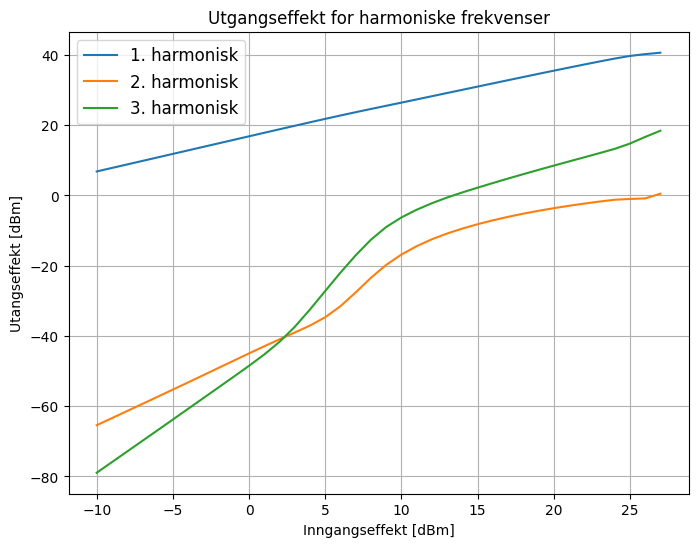

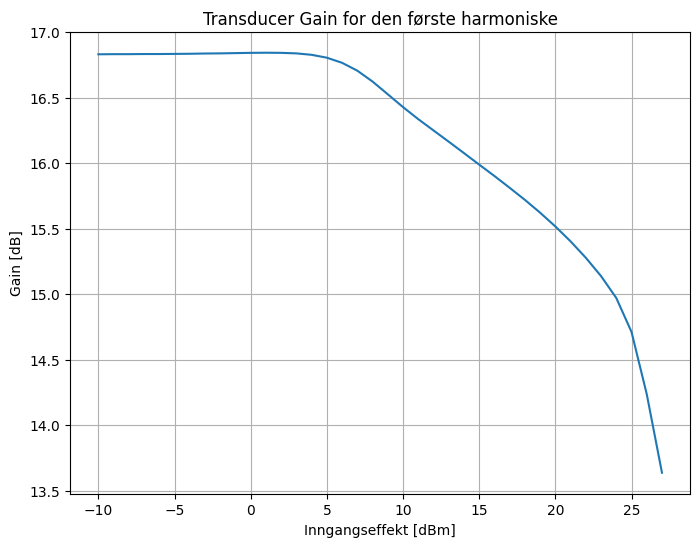

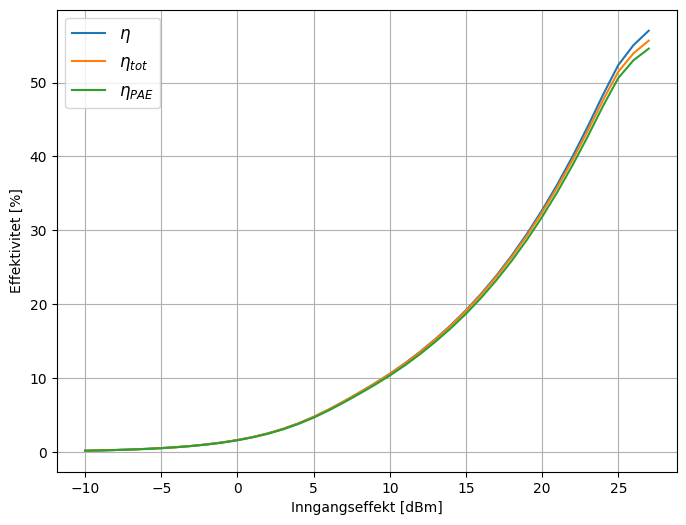

In [79]:
P_ut = np.loadtxt('Data/Simulering/Put.csv', delimiter=',',skiprows=21)
P_ut = pd.DataFrame(P_ut, columns=['P_in', 'P_ut1', 'P_ut2', 'P_ut3'])

TransGain = np.loadtxt('Data/Simulering/TransGain.csv', delimiter=',',skiprows=11)
TransGain = pd.DataFrame(TransGain, columns=['P_in', 'Gain'])

Effektivitet = np.loadtxt('Data/Simulering/Effektivitet.csv', delimiter=',',skiprows=21)
Effektivitet = pd.DataFrame(Effektivitet, columns=['P_in', 'DrainEff', 'TotalEff', 'PAE'])


plt.figure(figsize=(8, 6))
plt.plot(P_ut['P_in'], P_ut['P_ut1'], label='1. harmonisk')
plt.plot(P_ut['P_in'], P_ut['P_ut2'], label='2. harmonisk')
plt.plot(P_ut['P_in'], P_ut['P_ut3'], label='3. harmonisk')
plt.xlabel('Inngangseffekt [dBm]')
plt.ylabel('Utangseffekt [dBm]')
plt.legend(fontsize=12)
plt.title('Utgangseffekt for harmoniske frekvenser')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(TransGain['P_in'], TransGain['Gain'])
plt.xlabel('Inngangseffekt [dBm]')
plt.ylabel('Gain [dB]')
plt.title('Transducer Gain for den første harmoniske')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(Effektivitet['P_in'], Effektivitet['DrainEff'], label=r'$\eta$')
plt.plot(Effektivitet['P_in'], Effektivitet['TotalEff'], label=r'$\eta_{tot}$')
plt.plot(Effektivitet['P_in'], Effektivitet['PAE'], label=r'$\eta_{PAE}$')
plt.xlabel('Inngangseffekt [dBm]')
plt.ylabel('Effektivitet [%]')
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


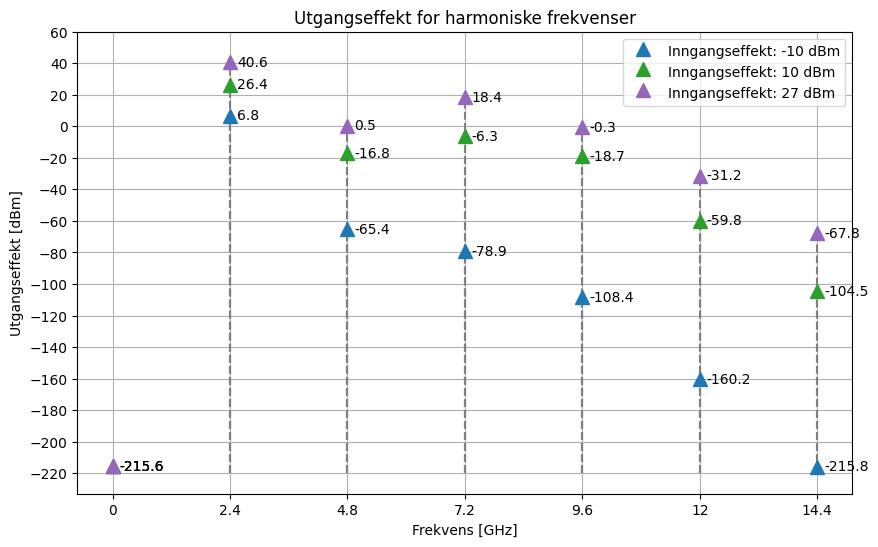

In [80]:
# Load the data
Spektrum = np.loadtxt('Data/Simulering/Spektrum1Tone.csv', delimiter=',', skiprows=16)

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(Spektrum, columns=['P_in', 'Frequency', 'Value'])

# Define the harmonics of 2.4 GHz
harmonic_frequencies = [0, 2.4, 4.8, 7.2, 9.6, 12, 14.4]  # GHz

# Initialize a new DataFrame to store the reshaped data
Spektrum1Tone = pd.DataFrame(columns=['P_in', 'DC', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6'])

# Group by P_in and reshape the data
for p_in, group in df.groupby('P_in'):
    row = [p_in] + [np.nan] * len(harmonic_frequencies)
    for i, harmonic in enumerate(harmonic_frequencies):
        value = group.loc[group['Frequency'] == harmonic * 1e9, 'Value'].values
        row[i + 1] = value[0] if len(value) > 0 else np.nan
    Spektrum1Tone.loc[len(Spektrum1Tone)] = row


min_value = Spektrum1Tone.iloc[:, 1:].min().min()
max_value = Spektrum1Tone.iloc[:, 1:].max().max()
step=20

# Desired input power
Power_values = [-10,10,27]  # dBm

# Plot the spectral lines at the desired input power
plt.figure(figsize=(10, 6))
for Power in Power_values:
    idx = (Spektrum1Tone['P_in'] == Power)
    markerline, stemlines, baseline = plt.stem(
        harmonic_frequencies, 
        Spektrum1Tone.loc[idx].values[0][1:], 
        linefmt='--', 
        markerfmt='^', 
        basefmt=' ', 
        label=f'Inngangseffekt: {Power} dBm',
        bottom = -220,
    )
    plt.setp(markerline, 'zorder', 3, 'markersize', 10)  # Set marker z-order and size
    plt.setp(stemlines, 'zorder', 2, 'color', 'gray')   # Set stem line z-order and color
    plt.setp(baseline, 'zorder', 1)  # Set baseline z-order

    for x, y in zip(harmonic_frequencies, Spektrum1Tone.loc[idx].values[0][1:]):
        plt.annotate(f'{y:.1f}', xy=(x, y), xytext=(5, -3), textcoords='offset points', fontsize=10, color='black')

plt.xticks(harmonic_frequencies, [f'{freq}' for freq in harmonic_frequencies]) 
plt.yticks(np.arange(np.floor(min_value / step) * step, np.ceil(max_value / step) * step + 1, step))
plt.xlabel('Frekvens [GHz]')
plt.ylabel('Utgangseffekt [dBm]')
plt.title('Utgangseffekt for harmoniske frekvenser')
plt.legend()
plt.grid(True)
plt.show()

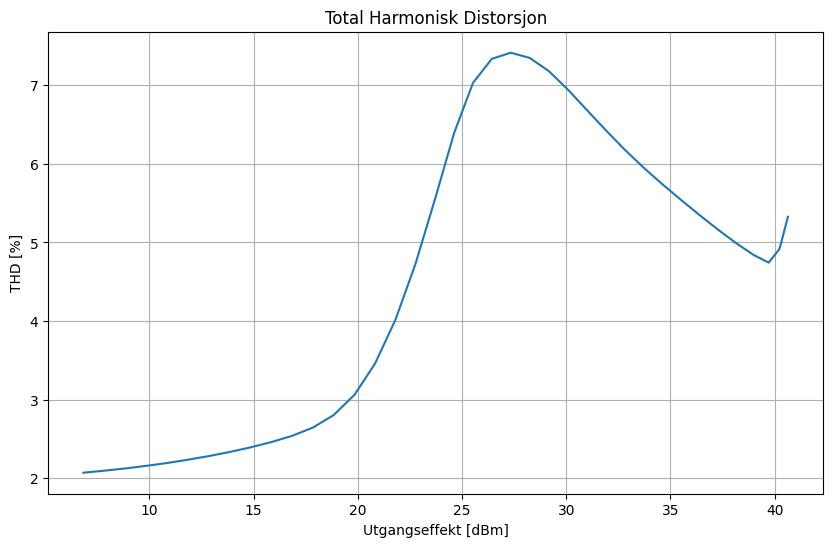

In [81]:
THD = np.loadtxt('Data/Simulering/THD1Tone.csv', delimiter=',', skiprows=11)
THD = pd.DataFrame(THD, columns=['P_ut', 'THD'])

plt.figure(figsize=(10, 6))
plt.plot(THD['P_ut'], THD['THD'])
plt.xlabel('Utgangseffekt [dBm]')
plt.ylabel('THD [%]')
plt.title('Total Harmonisk Distorsjon')
plt.grid(True)

### 2-Tone HB

In [82]:
## 123ABC